In [530]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mystery_func import get_mystery_function, get_actual_minimum, try_guesses, get_higher_order_mystery_function

In [371]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [441]:
mystery_func, _ = get_mystery_function()

We want to minimize our mystery function, but we can't graph it. So how do we do this?

Let's try some random values

In [442]:
our_minimum, guesses = try_guesses(mystery_func)

Enter a guess: 4
2.354198e+07
Enter a guess: 1
2.362935e+07
Enter a guess: 15
2.322304e+07
Enter a guess: 100
2.083190e+07
Enter a guess: 1000
3.492503e+06
Enter a guess: 100000
8.710706e+10
Enter a guess: 10000
6.319985e+08
Enter a guess: 8000
3.663305e+08
Enter a guess: 5000
1.028285e+08
Enter a guess: 2500
6.993503e+06


Let's see how we did:

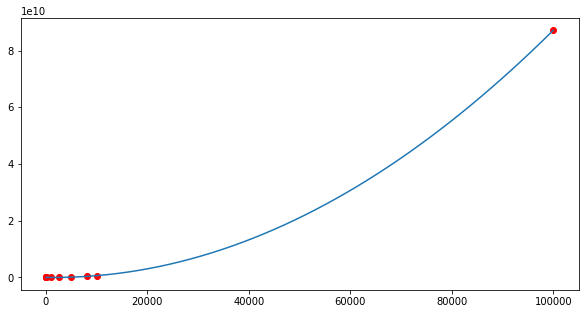

In [443]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(guesses, [mystery_func(guess) for guess in guesses], color = 'r')
x = np.linspace(np.min(guesses), np.max(guesses))
ax.plot(x, mystery_func(x))

In [444]:
our_minimum

3492503.0

In [445]:
actual_min, x_min = get_actual_minimum(mystery_func)

Minimum of 2.92e+04 at x = 1620.33


(28182.000000000015, 129182.00000000001)

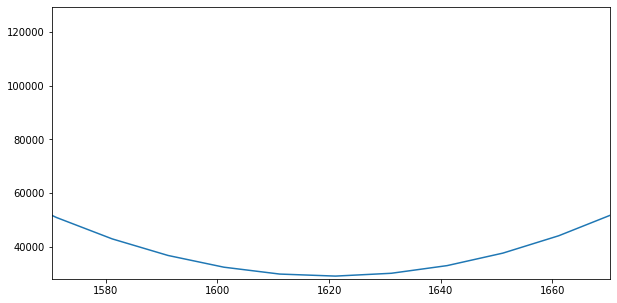

In [446]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(guesses, [mystery_func(guess) for guess in guesses], color = 'r')
x = np.linspace(np.min(guesses), np.max(guesses), 10000)
ax.plot(x, mystery_func(x))
ax.set_xlim(x_min - 50, x_min + 50)
ax.set_ylim(actual_min-1000, actual_min + 100000)

Maybe we can have our computer check a bunch of values to find the minimum

In [451]:
def random_search(mystery_func, n_guesses):
    guesses = []
    best_guess = None
    for _ in range(n_guesses):
        current_guess = np.random.randint(-1e6, 1e6)
        guesses.append(current_guess)
        current_result = mystery_func(current_guess)
        if not best_guess or current_result < best_result:
            best_guess, best_result = current_guess, current_result
    
    print(f"Our minimum was {best_result} from our guess x = {best_guess}")
    return guesses

In [452]:
guesses = random_search(mystery_func, 10000)

Our minimum was 74126 from our guess x = 1691


In [450]:
get_actual_minimum(mystery_func)

Minimum of 2.92e+04 at x = 1620.33


(29182.000000000015, 1620.3333345569856)

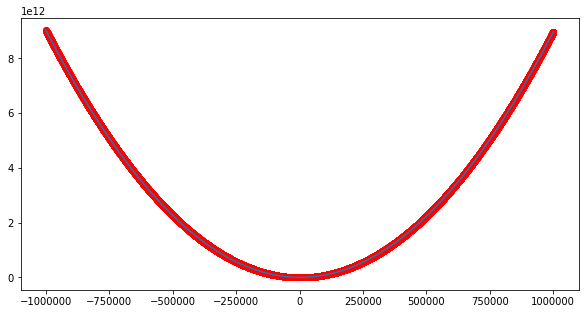

In [453]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(guesses, [mystery_func(guess) for guess in guesses], color = 'r')
x = np.linspace(np.min(guesses), np.max(guesses))
ax.plot(x, mystery_func(x))

(19182.000000000015, 129182.00000000001)

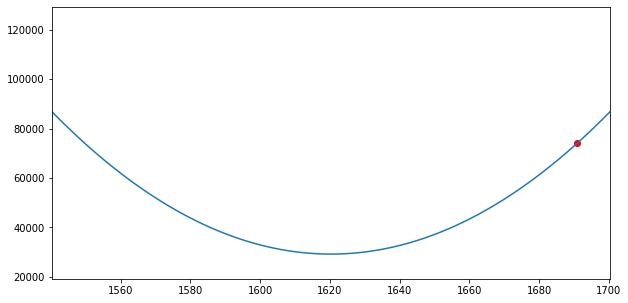

In [459]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(guesses, [mystery_func(guess) for guess in guesses], color = 'r')
x = np.linspace(np.min(guesses), np.max(guesses), 1000000)
ax.plot(x, mystery_func(x))
ax.set_xlim(x_min - 80, x_min + 80)
ax.set_ylim(actual_min-10000, actual_min + 100000)

Okay, this isn't getting us very far, but we actually have a secret weapon I didn't mention, we can also evaluate the derivative of our mystery function. How about we try a random value and evaluate the function and the derivative at that point.

Let's try a new mystery function

In [460]:
mystery_func, mystery_func_prime = get_mystery_function()

In [322]:
val = 30057
mystery_func(val), mystery_func_prime(val)

(1022119, 62)

In [461]:
our_minimum, guesses = try_guesses(mystery_func, deriv=mystery_func_prime)

Enter a guess: 0
Current value: 1.80e+06, current derivative: -1.87e+04
Enter a guess: 1000
Current value: 3.21e+07, current derivative: 7.93e+04
Enter a guess: 100
Current value: 4.14e+05, current derivative: -8.94e+03
Enter a guess: 150
Current value: 8.92e+04, current derivative: -4.04e+03
Enter a guess: 200
Current value: 9.50e+03, current derivative: 8.56e+02
Enter a guess: 175
Current value: 1.87e+04, current derivative: -1.59e+03
Enter a guess: 180
Current value: 1.20e+04, current derivative: -1.10e+03
Enter a guess: 185
Current value: 7.69e+03, current derivative: -6.14e+02
Enter a guess: 190
Current value: 5.84e+03, current derivative: -1.24e+02
Enter a guess: 195
Current value: 6.45e+03, current derivative: 3.66e+02


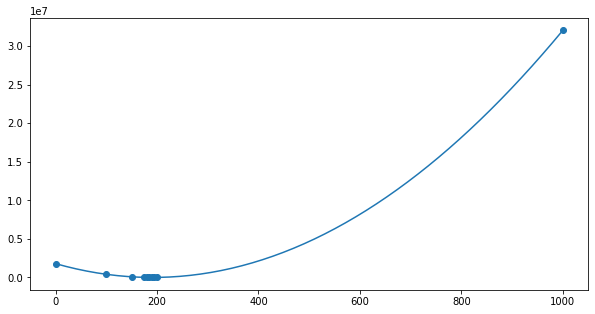

In [462]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(guesses, [mystery_func(guess) for guess in guesses])
x = np.linspace(np.min(guesses), np.max(guesses))
ax.plot(x, mystery_func(x))

In [463]:
our_minimum

5842.0

In [464]:
get_actual_minimum(mystery_func)

Minimum of 5.76e+03 at x = 191.27


(5763.551020408165, 191.2653063306109)

This is really getting us somewhere, we can definitely use these results to find the minimum.  

So now can we functionalize this process? Make it automatic?

In [465]:
def find_minimum(initial_guess, n_iterations, step_size):
    current_location = initial_guess
    for _ in range(n_iterations):
        current_val = mystery_func(current_location)
        current_slope = mystery_func_prime(current_location)
        if current_slope < 0:
            current_location += step_size
        elif current_slope > 0:
            current_location -= step_size
        else:
            break
    return current_location

In [470]:
initial_guess = np.random.randint(-5000, 5000)
find_minimum(initial_guess, 10000, 5)

189

This is getting really good, but we're still limited in precision by the step size. How can we take large enough steps that we get close to the minimum and then smaller steps as we get closer?

Maybe we can use the magnitude of the slope to decide how big of a step to take.

In [554]:
def gradient_descent(loss_function, derivative, initial_guess, n_iterations, alpha = 0.1):
    current_location = initial_guess
    guesses = [initial_guess]
    for _ in range(n_iterations):
        current_val = mystery_func(current_location)
        current_slope = mystery_func_prime(current_location)
        current_location += alpha * -current_slope
        guesses.append(current_location)
    return current_location, guesses

In [ ]:
get_complicated_mystery_function()

Okay so you may remember from calculus that we can actually set the derivative to 0 and solve to find the location of minima of a function. And we could certainly do that for these functions, so why is gradient descent useful? Because we will be trying to descend multivariable equations where we can't explicitly solve for the derivative.

This is where gradient descent really shines, when we have to use partial derivatives on a multivariable equation.

Quick Review: what is a partial derivative?

A partial derivative is something that is probably less intimidating than it sounds

Let's say we have a function f(x, y) = 5x^2 - 6y

We want to do the same thing we've been doing, minimize the function and hopefully use its derivative to help us do that.

But how do we take the derivative of a function with multiple variables. We take the partial derivative with respect to each variable in the equation.

So first we take the partial derivative with respect to x, treating y as a constant, and then the partial derivative with respect to y, treating x as a constant.

So when we take the partial derivative with respect to x, we treat y as a constant and we get:
df/dx = 10x

then for y we get:
df/dy = -6

Now rather than getting a single value when we evaluate the derivative of our function we get a vector
[10x, -6]

In [472]:
from mpl_toolkits import mplot3d

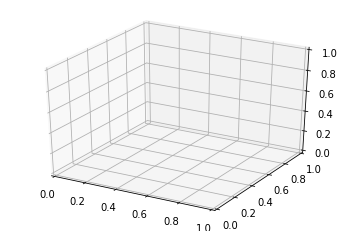

In [473]:
fig = plt.figure()
ax = plt.axes(projection='3d')

In [491]:
def f(x, y):
    return (x-20)**2 + (y+10)**2

x = np.linspace(-40, 40, 100)
y = np.linspace(-40, 40, 100)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

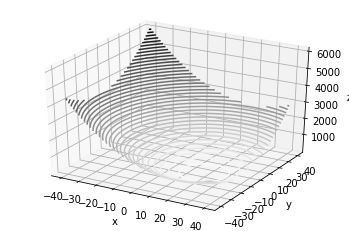

In [519]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

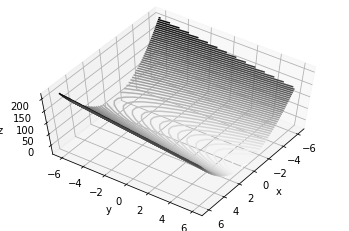

In [483]:
ax.view_init(60, 35)
fig

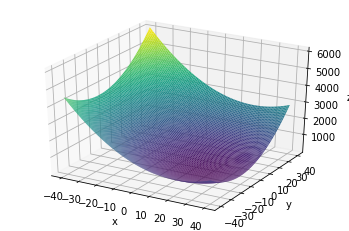

In [522]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [485]:
x = Symbol('x')
y = Symbol('y')
multi_var_func = (x-20)**2 + (y+10)**2

In [487]:
multi_var_func.diff(x)

2*x - 40

In [488]:
multi_var_func.diff(y)

2*y + 20

Okay this is all good and well, but what does this have to do with machine learning? We can use gradient descent to minimize a loss function.

In [495]:
!ls data

Fish.csv


In [497]:
df = pd.read_csv('data/Fish.csv')

In [498]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [499]:
df.shape

(159, 7)

Let's try a linear regression using just Height and Width to predict Weight!

So we want to figure out the best coefficients for an equation Weight = B_0 + B_1 * Height + B_2 * Width

We can do this using gradient descent by minimizing the loss function.

The loss function is the sum of squared differences between Actual Weight and our equation using coefficients and Height and Width B_0 + B_1 * Height + B_2 * Width

For simplicity's sake and because I think it's reasonable to assume a fish with 0 height and 0 width will have 0 weight, we can ignore the constant (and because it lets us continue to graph our results).

In [514]:
B_1 = Symbol('B_1')
B_2 = Symbol('B_2')

In [526]:
loss_func_sym = sum([(row.Weight - (B_1 * row.Height + B_2 * row.Width))**2 for idx, row in df[['Weight', 'Height', 'Width']].iterrows()])

In [527]:
loss_func_sym.diff(B_1)

31397.65349464*B_1 + 14412.50010058*B_2 - 1487542.63982

In [528]:
loss_func_sym.diff(B_2)

14412.50010058*B_1 + 7103.560108*B_2 - 728610.0451

In [529]:
loss_func = lambdify((B_1, B_2), loss_func_sym)

In [531]:
loss_func_B_1_prime = lambdify((B_1, B_2), loss_func_sym.diff(B_1))
loss_func_B_2_prime = lambdify((B_1, B_2), loss_func_sym.diff(B_2))

Okay so let's try our guesses again!

In [532]:
loss_func(0, 0)

45475024.41

In [533]:
loss_func_B_1_prime(0, 0)

-1487542.63982

In [534]:
loss_func_B_2_prime(0, 0)

-728610.0451

In [535]:
loss_func(100, 100)

160490824.937

In [537]:
loss_func_B_1_prime(100, 100), loss_func_B_2_prime(100, 100)

(3093472.719702, 1422995.975758)

In [540]:
x = np.linspace(-400, 400, 1000)
y = np.linspace(-400, 400, 1000)

X, Y = np.meshgrid(x, y)
Z = loss_func(X, Y)

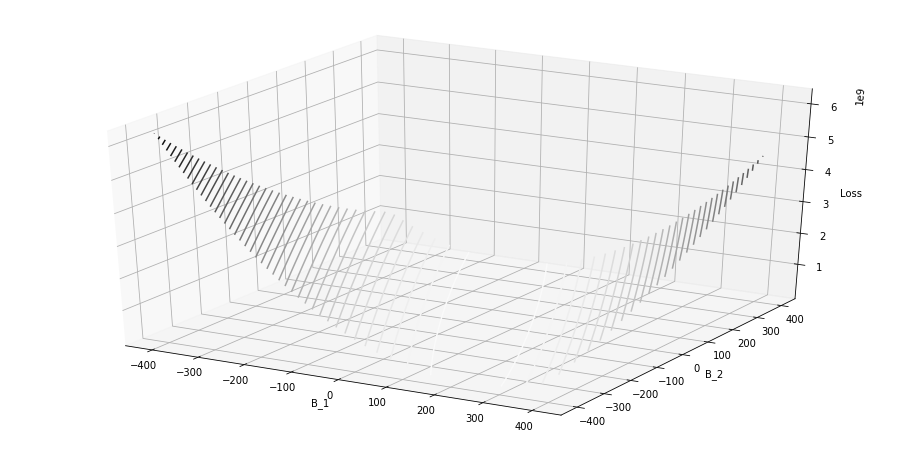

In [548]:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('B_1')
ax.set_ylabel('B_2')
ax.set_zlabel('Loss');

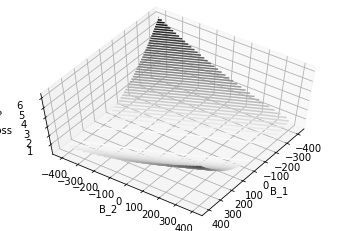

In [546]:
ax.view_init(60, 35)
fig

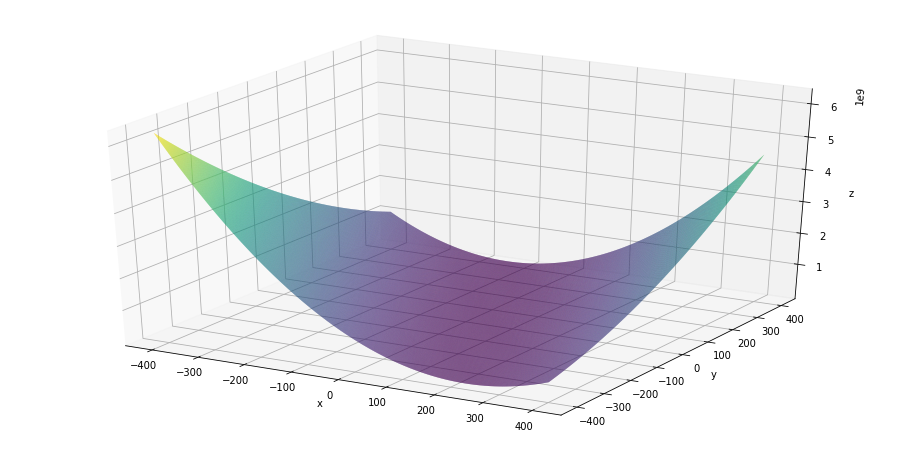

In [549]:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

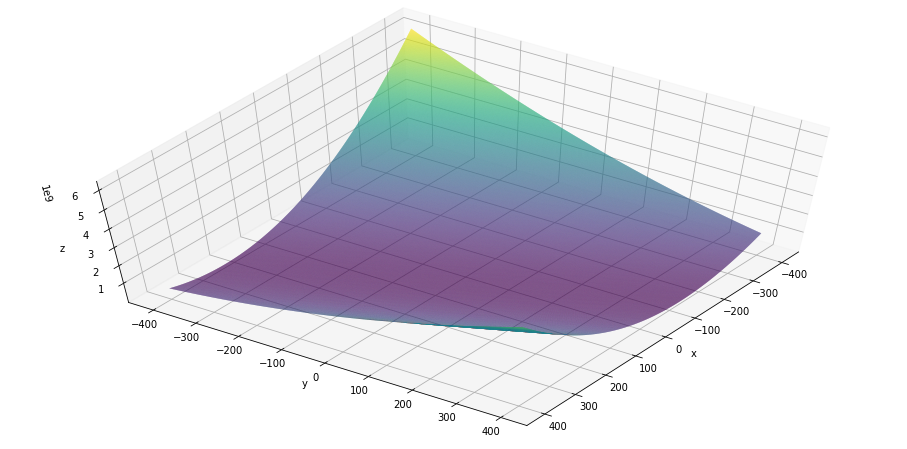

In [550]:
ax.view_init(60, 35)
fig

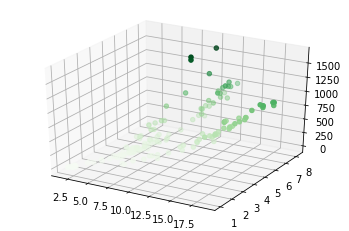

In [551]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
'''zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')'''

# Data for three-dimensional scattered points
zdata = df['Weight']
xdata = df['Height']
ydata = df['Width']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

In [555]:
def multi_var_gradient_descent(loss_function, derivatives, initial_guess, max_iterations, alpha = 0.1):
    current_location = initial_guess
    guesses = [initial_guess]
    for _ in range(max_iterations):
        current_val = loss_function(current_location)
        current_slope = np.array([derivative(current_location) for derivative in derivatives])
        current_location += alpha * -current_slope
        guesses.append(current_location)
    return current_location, guesses

In [557]:
multi_var_gradient_descent(loss_func, [loss_func_B_1_prime, loss_func_B_2_prime], np.array([1, 1]),1000, alpha = 0.1)

TypeError: _lambdifygenerated() missing 1 required positional argument: 'B_2'